In [84]:
import torch
from torch import nn 
from torch.nn import functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
import time
import math
import seaborn as sns
import numpy as np

In [95]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__() 

        self.fc1 = nn.Linear(2, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 20)
        self.fc4 = nn.Linear(20, 20)
        self.fc5 = nn.Linear(20, 20)
        self.fc6 = nn.Linear(20, 20)
        self.fc7 = nn.Linear(20, 20)
        self.fc8 = nn.Linear(20, 20)
        self.fc9 = nn.Linear(20, 1)
        
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = torch.tanh(self.fc4(x))
        x = torch.tanh(self.fc5(x))
        x = torch.tanh(self.fc6(x))
        x = torch.tanh(self.fc7(x))
        x = torch.tanh(self.fc8(x))
        x = torch.tanh(self.fc9(x))
        return x

In [96]:
net = NN()
print(net)

params = list(net.parameters())
#print(len(params))
for par in params:
    print(par.shape)

NN(
  (fc1): Linear(in_features=2, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=20, bias=True)
  (fc5): Linear(in_features=20, out_features=20, bias=True)
  (fc6): Linear(in_features=20, out_features=20, bias=True)
  (fc7): Linear(in_features=20, out_features=20, bias=True)
  (fc8): Linear(in_features=20, out_features=20, bias=True)
  (fc9): Linear(in_features=20, out_features=1, bias=True)
)
torch.Size([20, 2])
torch.Size([20])
torch.Size([20, 20])
torch.Size([20])
torch.Size([20, 20])
torch.Size([20])
torch.Size([20, 20])
torch.Size([20])
torch.Size([20, 20])
torch.Size([20])
torch.Size([20, 20])
torch.Size([20])
torch.Size([20, 20])
torch.Size([20])
torch.Size([20, 20])
torch.Size([20])
torch.Size([1, 20])
torch.Size([1])


In [97]:
class Model:
    def __init__(self):
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        print(f"Device used: {self.device}")
        self.model = NN().to(self.device)
        
        #Max iteration
        self.max_iter = 1000
        
        #Criterion for loss 
        self.criterion = nn.MSELoss()
        
        #Optimizer
        #self.optimizer = optim.Adam(self.model.parameters())
        
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"
        )
        
        #Initialization for training
        self.x_step = 0.1
        self.t_step = 0.1
        x = torch.arange(-1, 1+self.x_step, self.x_step) #create grid for x-axis
        t = torch.arange(0, 1 + self.t_step, self.t_step) #create grid for t-axis
        
        #Create grid for solution
        self.grid = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T.to(self.device) # Create grid of 2D points
        self.grid.requires_grad = True
        
        #Training data
        bound_1 = torch.stack(torch.meshgrid(x[0], t)).reshape(2, -1).T # Points for first boundary condition 
        bound_2 = torch.stack(torch.meshgrid(x[-1], t)).reshape(2, -1).T #Points for second boundary condition
        initial = torch.stack(torch.meshgrid(x, t[0])).reshape(2, -1).T # Points for initial condition for x at t=0
        
        self.train_points = torch.cat([bound_1, bound_2, initial]).to(self.device) # Training points as a grid
        u_b1 = torch.zeros(len(bound_1))
        u_b2 = torch.zeros(len(bound_2))
        u_initial = -torch.sin(math.pi * initial[:, 0])# use initial condition from paper (Dirichlet boundary conditions)
        self.y_train = torch.cat([u_b1, u_b2, u_initial])
        self.y_train = self.y_train.unsqueeze(1).to(self.device)
        """
        self.X = self.X.to(device)
        self.X_train = self.X_train.to(device)
        self.y_train = self.y_train.to(device)
        self.X.requires_grad = True
        """
        self.iter = 1


    
    def loss(self):
        self.optimizer.zero_grad()
        
        y = self.model(self.train_points)
        loss = self.criterion(y, self.y_train) #Compute first part of loss
        u = self.model(self.grid)
        
        #Compute gradients of grid with respect to u and t
        du_dX = torch.autograd.grad(inputs=self.grid, outputs=u, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        du_dt = du_dX[:, 1]
        du_dx = du_dX[:, 0]
        du_dx2 = torch.autograd.grad(inputs=self.grid, outputs=du_dX, grad_outputs=torch.ones_like(du_dX), retain_graph=True, create_graph=True)[0][:, 0]
        
        loss += self.criterion(du_dt + u.squeeze() * du_dx, 0.01/math.pi *du_dx2) #Second part of loss, using f(t,x) as in paper
        
        loss.backward()
        #Print loss every 100 iteration
        if self.iter % 100 == 0: 
            print(self.iter, loss.item())
        self.iter = self.iter + 1
        return loss

    def train(self):
        for i in range(self.max_iter):
            self.optimizer.step(self.loss)
        #self.lbfgs.step(self.loss)
        
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(self.device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(self.device)

        self.model.eval()
        u = self.model(torch.cat([x, t], dim=1))
        u = u.detach().cpu().numpy()
        return u


In [98]:
model = Model()
model.train()

Device used: cuda:0
100 0.09310893714427948
200 0.05522597208619118
300 0.03789825737476349
400 0.027962053194642067
500 0.023277398198843002
600 0.02043379843235016
700 0.016788149252533913
800 0.014300373382866383
900 0.01280038058757782
1000 0.011477893218398094
1100 0.009605629369616508
1200 0.008125239051878452
1300 0.006386730819940567
1400 0.005440451204776764
1500 0.004732728004455566
1600 0.004442598670721054
1700 0.003764280118048191
1800 0.0032550785690546036
1900 0.0029895922634750605
2000 0.0027882365975528955
2100 0.0024857772514224052
2200 0.0023600617423653603
2300 0.0022991341538727283
2400 0.002298193983733654
2500 0.002296842634677887
2600 0.002296800957992673
2700 0.0022968004923313856
2800 0.0022968596313148737
2900 0.0022968356497585773
3000 0.0022968004923313856
3100 0.002298193983733654
3200 0.002296842634677887
3300 0.002296800957992673
3400 0.0022968004923313856
3500 0.0022968596313148737
3600 0.0022968356497585773
3700 0.0022968004923313856
3800 0.00229819398

In [99]:
h = 0.01
k = 0.01
x = torch.arange(-1, 1, h)
t = torch.arange(0, 1, k)

# exact solution
grid = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T
grid = grid.to(model.grid.device)

In [100]:
mod = model.model
mod.eval()
with torch.no_grad():
    y_pred = mod(grid).reshape(len(x), len(t)).cpu().numpy()

<AxesSubplot:>

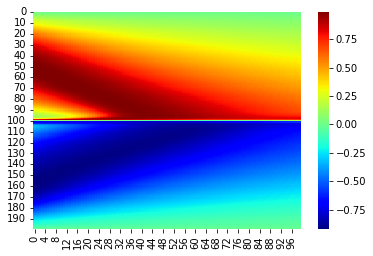

In [101]:
sns.heatmap(y_pred, cmap='jet')

In [102]:
import scipy.io


data = scipy.io.loadmat('burgers_shock.mat')

t = data['t'].flatten()[:,None] #(100, 1)
x = data['x'].flatten()[:,None] #(256, 1)
Exact = np.real(data['usol']).T #(100, 256)

X, T = np.meshgrid(x,t) #(100, 256) for each

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None])) #(25600, 2)
u_star = Exact.flatten()[:,None] #(25600, 1)



u_pred = model.predict(X_star)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u)) #use this metric to compare model performance                   

Error u: 1.085630e-01


In [5]:
t_step = 0.1
x_step = 0.1
x = torch.arange(-1, 1+x_step, x_step) #create grid for x-axis #21 points from -1 to 1
t = torch.arange(0, 1 + t_step, t_step) #create grid for t-axis #11 points from 0 to 1

#Create grid for solution
grid = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T # Create grid of 2D points #231, 2
grid.requires_grad = True

#Training data
bound_1 = torch.stack(torch.meshgrid(x[0], t)).reshape(2, -1).T # Points for first boundary condition x=-1 (11,2)
bound_2 = torch.stack(torch.meshgrid(x[-1], t)).reshape(2, -1).T #Points for second boundary condition x=1 (11,2)
initial = torch.stack(torch.meshgrid(x, t[0])).reshape(2, -1).T # Points for initial condition for x at t=0 (21,2)

train_points = torch.cat([bound_1, bound_2, initial]) # Training points as a grid #43,2
u_b1 = torch.zeros(len(bound_1)) #11
u_b2 = torch.zeros(len(bound_2)) #11
u_initial = -torch.sin(math.pi * initial[:, 0])# use initial condition from paper (Dirichlet boundary conditions)
# -sin(pi*x) avec x from -1 to 1 # shape 21
y_train = torch.cat([u_b1, u_b2, u_initial]) #true label pour ic and bc1 and bc2 of size 43
y_train = y_train.unsqueeze(1) #43 1

In [44]:
h = 0.01
k = 0.01
x = torch.arange(-1, 1, h) #200
t = torch.arange(0, 1, k) #100

# exact solution
grid = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T #20000 pairs